In [148]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of preprocessing failed: Traceback (most recent call last):
  File "/home/sunggil/anaconda3/envs/tf1/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/sunggil/anaconda3/envs/tf1/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/sunggil/anaconda3/envs/tf1/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/sunggil/anaconda3/envs/tf1/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/sunggil/anaconda3/envs/tf1/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "/home/sunggil/anaconda3/envs/tf1/lib/python3.7/site-packages/IPython/extensions/autorelo

In [169]:
from postprocessing import restore_future_price

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

/home/sunggil/anaconda3/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunggil/anaconda3/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunggil/anaconda3/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunggil/anaconda3/envs/tf1/lib/python3.7/site-

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [149]:
import preprocessing
from preprocessing import data_load
from preprocessing import remove_dummy_columns
from preprocessing import corss_train_test_split
from preprocessing import create_time_table_X
from preprocessing import CreateTarget
from preprocessing import next_batch
from preprocessing import load_important_variables
from preprocessing import load_important_train_test
from preprocessing import load_timeseries_tensor_train_test

In [5]:
import numpy as np
import pandas as pd

In [177]:
from openpyxl import load_workbook

In [6]:
tf.enable_eager_execution()

In [178]:
def valuation(path, confu_mat,MSE):
    recall = round(confus_mat[0][0]/sum(confus_mat[:,0]),3)
    precision = round(confus_mat[0][0]/sum(confus_mat[0]),3)
    accu = round((confus_mat[0][0]+confus_mat[1][1])/sum(sum(confus_mat)),3)
    
    wb = load_workbook(file_path+file_name, data_only=True)
    sheet1 = wb.active
    
    sheet1.cell(2,7,'TRUE')
    sheet1.cell(3,7,'0')
    sheet1.cell(3,8,'1')

    sheet1.cell(3,6,'PREDICTION')
    sheet1.cell(4,6,'0')
    sheet1.cell(5,6,'1')

    sheet1.cell(4,7,confus_mat[0][0])
    sheet1.cell(4,8,confus_mat[0][1])
    sheet1.cell(5,7,confus_mat[1][0])
    sheet1.cell(5,8,confus_mat[1][1])


    sheet1.cell(3,9,'accuracy')
    sheet1.cell(3,10,accu)

    sheet1.cell(4,9,'precision(하락)')
    sheet1.cell(4,10,precision)

    sheet1.cell(5,9,'recall(하락)')
    sheet1.cell(5,10,recall)

    sheet1.cell(6,9,'MSE')
    sheet1.cell(6,10,MSE)
    
    wb.save(file_path+file_name)
    

In [7]:
def create_input_data_4D_part(training_part,part, target_name, timestep, future_day):
    train = training_part[part][0]
    test = training_part[part][1]
    
    train_price = np.array(train[target_name])
    test_price = np.array(test[target_name])
    train_labels = CreateTarget.semi_trend_ratio(train_price, future_day, timestep)
    test_labels = CreateTarget.semi_trend_ratio(test_price, future_day, timestep)
    
    train_labels = np.expand_dims(train_labels, axis = -1)
    test_labels = np.expand_dims(test_labels, axis = -1)
    
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    
    train_X = create_time_table_X(train_scaled,timestep)
    test_X = create_time_table_X(test_scaled,timestep)

    train_X = np.expand_dims(train_X, axis = -1)
    test_X = np.expand_dims(test_X, axis = -1)

    train_X = train_X[:len(train_labels)]
    test_X = test_X[:len(test_labels)]
    
    return (train_X, train_labels, test_X, test_labels)

In [8]:
def create_learning_dataset(item_name, train_data, test_data, future_day,time_step, price_col,n_variable = None):
    train_price = np.array(train_data[price_col]) #train/test 데이터의 종가 추출
    test_price = np.array(test_data[price_col])
    
    y_train = CreateTarget.semi_trend_ratio(train_price, future_day,time_step) #train/test 수익률 계산하여 label생성
    y_test = CreateTarget.semi_trend_ratio(test_price, future_day,time_step)
    
    y_train= np.expand_dims(y_train, axis = -1)
    y_test = np.expand_dims(y_test, axis = -1)
    
    if n_variable !=None:
        train_data = load_important_variables(train_data, item_name, future_day, n_variable)
        test_data = load_important_variables(test_data, item_name, future_day, n_variable)
        
    scaler = StandardScaler()  
    train_data_scaled = scaler.fit_transform(train_data) #input data 정규화
    test_data_scaled = scaler.transform(test_data) 
    
    X_train = create_time_table_X(train_data_scaled,time_step) #input 데이터 time slice 하여 3차원 input 데이터 생성
    X_test = create_time_table_X(test_data_scaled,time_step)
    
    return (X_train[:-future_day], y_train, X_test[:-future_day], y_test)

In [9]:
def loss_fn(model, X_data, labels):
    logits = model(X_data, training = True)
    loss = tf.reduce_mean(tf.square(logits - labels))
    return loss

def grad(model, X_data, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, X_data, labels)
    
    return tape.gradient(loss, model.variables)

def evaluate(model, X_data, labels):
    logits = model(X_data, training = False)
    MES = tf.reduce_mean(tf.square(logits - labels)) 
    return MES


In [10]:
def training(model, X_train,y_train, X_test, y_test, batch_size, n_epochs ):
    for epoch in range(n_epochs):
        X, labels = next_batch(X_train, y_train, batch_size)

        grads = grad(model, X, labels)
        optimizer.apply_gradients(zip(grads, model.variables))
        if epoch%100 == 0:
            loss = loss_fn(model, X, labels)
            train_MSE = evaluate(model, X, labels)

            test_MSE =  evaluate(model, X_test, y_test)

            print('Epoch :', epoch+1, ' loss =', loss.numpy(), ' train MSE =', train_MSE.numpy(),' test MSE =', test_MSE.numpy())
    return  model(X_test, training = False)

In [ ]:
def CNN_LSTM(time_step):
    with tf.device('/gpu:2') :
        inputs = keras.Input(shape = (time_step,3917,1))
        conv1 = keras.layers.Conv2D(filters = 1, kernel_size = (1,3917), strides = (1,1),padding = 'SAME', activation = tf.nn.elu,kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
        pool1 = keras.layers.MaxPool2D(pool_size = (10,10),padding = 'SAME')(conv1)
        pool2 = tf.reshape (pool1,(-1,pool1.shape[1],pool1.shape[2]))
        #pool3_flat = keras.layers.Flatten()(pool3)
        #dense4 = keras.layers.Dense(units= 50,kernel_regularizer=keras.regularizers.l2(0.001), activation = tf.nn.elu)(pool2)
        #drop4 = keras.layers.Dropout(rate = 0.9)(dense4)
        #CNN_output = keras.layers.Dense(units = 50)(drop4)
        
        
        lstm5 = keras.layers.LSTM(units = 50, activation = tf.nn.relu6,return_sequences=True)(pool2)
        drop5 = keras.layers.TimeDistributed(keras.layers.Dropout(rate = .5))(lstm5)
        lstm6 = keras.layers.LSTM(units = 50, activation = tf.nn.relu6)(drop5)
        drop6 = keras.layers.Dropout(rate = .9)(lstm6)

        dense8 = keras.layers.Dense(units = 64)(drop6)
        drop8 = keras.layers.Dropout(rate = .9)(dense8)
        logits = keras.layers.Dense(units = 1)(drop8)

    return keras.Model(inputs = inputs, outputs = logits)

In [3]:
38*8

304

In [ ]:
CNN_LSTM(time_step)

In [11]:
def create_CNN(time_step,n_input):
    with tf.device('/gpu:0') :
        inputs = keras.Input(shape = (time_step,n_input,1))
        conv1 = keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'SAME', activation = tf.nn.relu)(inputs)
        pool1 = keras.layers.MaxPool2D(padding = 'SAME')(conv1)
        conv2 = keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'SAME', activation =tf.nn.relu)(pool1)
        pool2 = keras.layers.MaxPool2D(padding = 'same')(conv2)
        conv3 = keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'SAME', activation = tf.nn.relu)(pool2)
        pool3 = keras.layers.MaxPool2D(padding = 'SAME')(conv3)
        pool3_flat = keras.layers.Flatten()(pool3)
        dense4 = keras.layers.Dense(units= 256, activation = tf.nn.relu)(pool3_flat)
        drop4 = keras.layers.Dropout(rate = 0.4)(dense4)
        logits = keras.layers.Dense(units = 1)(drop4)

    return keras.Model(inputs = inputs, outputs = logits)

#,kernel_regularizer=keras.regularizers.l2(0.001)

In [12]:
model_CNN = create_CNN(200,100)
model_CNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 100, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 50, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 50, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 13, 128)       0     

In [137]:
def create_LSTM(time_step,n_input):
    #with tf.device('/gpu:1') :
    inputs = keras.Input(shape = (time_step,n_input))    
    #lstm1 = keras.layers.LSTM(units = 300, activation = tf.nn.relu6, return_sequences=True)(inputs)
    lstm1 = keras.layers.CuDNNLSTM(units = 300, return_sequences=True)(inputs)

    #drop1 = keras.layers.TimeDistributed(keras.layers.Dropout(rate = .5))(lstm1)
    drop1 = keras.layers.Dropout(rate = .3)(lstm1)

    #lstm2 = keras.layers.LSTM(units = 300, activation = tf.nn.relu6,return_sequences=True)(drop1)
    lstm2 = keras.layers.CuDNNLSTM(units = 300,return_sequences=True)(drop1)
    drop2 = keras.layers.Dropout(rate = .3)(lstm2)

    #lstm3 = keras.layers.LSTM(units = 300, activation = tf.nn.relu6,return_sequences=True)(drop2)
    lstm3 = keras.layers.CuDNNLSTM(units = 300,return_sequences=True)(drop2)
    drop3 = keras.layers.Dropout(rate = .3)(lstm3)

    stacked_rnn_outputs = tf.reshape(drop3,[-1,300])
    stacked_outputs = keras.layers.Dense(units = 1)(stacked_rnn_outputs)
    logits = tf.reshape(stacked_outputs,[-1,time_step, 1])
    #dense3 = keras.layers.Dense(units = 64)(drop2)
    #drop3 = keras.layers.Dropout(rate = .9)(dense3)
    #logits = keras.layers.TimeDistributed(keras.layers.Dense(units = 1))(drop3)

    return keras.Model(inputs = inputs, outputs = logits)

In [54]:
np.array(predict_LSTM[0])

array([[  2.6645393 ],
       [ -1.6320925 ],
       [ -7.2528944 ],
       [ -4.394966  ],
       [ -4.10991   ],
       [ -7.5743537 ],
       [-12.021382  ],
       [-12.159553  ],
       [ -3.4653382 ],
       [  5.661732  ],
       [  6.8147616 ],
       [  7.2207837 ],
       [  9.414165  ],
       [ 12.075141  ],
       [ 12.870138  ],
       [ 14.164834  ],
       [ 14.056041  ],
       [ 16.214132  ],
       [ 17.885708  ],
       [ 18.816132  ],
       [ 18.397877  ],
       [ 16.78931   ],
       [ 15.563253  ],
       [ 14.36325   ],
       [ 13.651658  ],
       [ 13.160334  ],
       [ 12.912563  ],
       [ 13.268429  ],
       [ 13.724841  ],
       [ 13.64328   ],
       [ 13.423542  ],
       [ 14.231275  ],
       [ 15.659476  ],
       [ 17.024817  ],
       [ 15.4416685 ],
       [ 13.764699  ],
       [ 13.621931  ],
       [ 13.563576  ],
       [ 14.297652  ],
       [ 14.330974  ],
       [ 13.354017  ],
       [ 12.027668  ],
       [ 12.477649  ],
       [ 12

In [136]:
item_name = 'SK텔레콤'
data = data_load(item_name)
data = remove_dummy_columns(data)

##Database connection successful!
[success] enterprise_absolute_value_indicator
[success] enterprise_consensus_estimate
[success] enterprise_dividend
[success] enterprise_financial_ratio
[success] enterprise_financial_statements
[success] enterprise_fixed_result_news
[success] enterprise_relative_value_indicator
[success] enterprise_stock
[success] enterprise_tentative_result
[success] market_financial_institution_reception_trend
[success] market_fund_investors
[success] market_money_around_market
[success] market_retirement_pension
[success] market_stock_cam
[success] market_trends_elw
[success] market_trends_investor_bond
[success] market_trends_investor_dollar
[success] market_trends_investor_eur
[success] market_trends_investor_gold
[success] market_trends_investor_index
[success] market_trends_investor_jpy
[success] market_trends_investor_pork
[success] market_trends_investor_rates
[success] market_trends_investor_stock
[success] market_trends_program
[success] economy_employ
[suc

In [192]:
target_name = '수정주가(원)'
time_step = 200
future_day = 60
n_epochs = 5000
batch_size = 50
learning_rate = 0.001
n_input = 100
var_method = 'RF'

In [193]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
model_LSTM = create_LSTM(time_step,n_input)
model_LSTM.summary()


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 200, 100)]        0         
_________________________________________________________________
cu_dnnlstm_21 (CuDNNLSTM)    (None, 200, 300)          482400    
_________________________________________________________________
dropout_31 (Dropout)         (None, 200, 300)          0         
_________________________________________________________________
cu_dnnlstm_22 (CuDNNLSTM)    (None, 200, 300)          722400    
_________________________________________________________________
dropout_32 (Dropout)         (None, 200, 300)          0         
_________________________________________________________________
cu_dnnlstm_23 (CuDNNLSTM)    (None, 200, 300)          722400    
_________________________________________________________________
dropout_33 (Dropout)         (None, 200, 300)          0  

In [194]:
idx = round(len(data)*80/100)

In [195]:
train_data = data[:idx]
test_data = data[idx:]

In [196]:
X_train, y_train, X_test, y_test = load_important_train_test(data,item_name, future_day, target_name, 'trend_ratio',n_input,var_method)    
X_train, y_train, X_test, y_test = load_timeseries_tensor_train_test(X_train, y_train, X_test, y_test,time_step)

/home/sunggil/project/market_prediction/code/preprocessing.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = target


training size : 4660 test size : 1165


In [197]:
predict_LSTM = training(model_LSTM, X_train,y_train, X_test, y_test, batch_size, n_epochs )

Epoch : 1  loss = 335.97983  train MSE = 335.69547  test MSE = 67.41674
Epoch : 101  loss = 83.285065  train MSE = 81.620995  test MSE = 93.18936
Epoch : 201  loss = 80.11048  train MSE = 78.38063  test MSE = 92.51435
Epoch : 301  loss = 143.44095  train MSE = 140.27745  test MSE = 89.14215
Epoch : 401  loss = 108.80809  train MSE = 107.16847  test MSE = 89.37231
Epoch : 501  loss = 107.6175  train MSE = 104.29323  test MSE = 86.47764
Epoch : 601  loss = 66.97924  train MSE = 64.772896  test MSE = 87.21824
Epoch : 701  loss = 22.43886  train MSE = 20.337885  test MSE = 87.9647
Epoch : 801  loss = 21.933382  train MSE = 19.224348  test MSE = 87.921364
Epoch : 901  loss = 26.588362  train MSE = 23.294085  test MSE = 89.50172
Epoch : 1001  loss = 21.707743  train MSE = 18.545902  test MSE = 89.4998
Epoch : 1101  loss = 27.714115  train MSE = 24.023678  test MSE = 90.74405
Epoch : 1201  loss = 10.941653  train MSE = 8.486635  test MSE = 87.343735
Epoch : 1301  loss = 12.307472  train MSE =

In [198]:
y_pred_time = np.array(predict_LSTM)[0:,-1]
y_test_time = y_test[0:,-1]


In [199]:
MSE = round((sum((y_pred_time-y_test_time)**2)/len(y_pred_time))[0],3)


In [200]:

X_test_price = data[len(X_train):][target_name]

y_test_price = restore_future_price(X_test_price[time_step-1:], y_test_time.reshape(-1), future_day)
y_pred_price = restore_future_price(X_test_price[time_step-1:], y_pred_time.reshape(-1), future_day)


In [201]:
file_name = '/futureday'+str(future_day)+'_timestep'+str(time_step)+'_nInput'+str(n_input)+'.xlsx'
file_path = '../result/'+'LSTM_'+var_method+'/'+item_name

result_df = pd.DataFrame({"ratio_r":y_test_time.reshape(-1), "ratio_p":y_pred_time.reshape(-1), "price_r":y_test_price, "price_p":y_pred_price})
result_df.to_excel(file_path+file_name)    


In [202]:
y_pred_up_down = list()
y_test_up_down = list()
for i in range(len(y_pred_time)):

    if y_pred_time[i] < 0 :
        y_pred_up_down.append(0)
    else:
        y_pred_up_down.append(1)

for i in range(len(y_test_time)):    
    if y_test_time[i] < 0 :
        y_test_up_down.append(0)
    else:
        y_test_up_down.append(1)  

confus_mat = confusion_matrix(y_pred_up_down,y_test_up_down)

valuation(file_path+file_name,confus_mat,MSE)

In [135]:
print('var_model :', var_method, ', train model : LSTM' ,', MSE :', MSE,', Accuracy :',accu, ', Precision :', precision, ', Recall :', recall)

var_model : Lasso , train model : LSTM , MSE : 98.76 , Accuracy : 0.555 , Precision : 0.506 , Recall : 0.293


In [129]:
X_train, y_train, X_test, y_test = create_learning_dataset(item_name, train_data, test_data, future_day,time_step, target_name,n_variable = n_input)

In [131]:
y_train.shape

(4449, 1)

In [127]:
X_test

(918, 200, 100)

In [123]:
4509-4449

60

In [141]:
model_LSTM = create_LSTM(time_step,n_input)
model_LSTM.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 200, 100)]        0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 200, 300)          481200    
_________________________________________________________________
dropout_15 (Dropout)         (None, 200, 300)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 200, 300)          721200    
_________________________________________________________________
dropout_16 (Dropout)         (None, 200, 300)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dropout_17 (Dropout)         (None, 300)               0  

In [137]:
model_CNN = create_CNN(time_step,n_input)
model_CNN.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 200, 100, 1)]     0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 200, 100, 32)      320       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 100, 50, 32)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 100, 50, 64)       18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 50, 25, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 50, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 25, 13, 128)       0  

In [143]:
y_train.shape

(4449, 1)

In [21]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

/home/sunggil/project/market_prediction/code/preprocessing.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = target


training size : 4660 test size : 1165


In [20]:
predict_LSTM = training(model_LSTM2, X_train,y_train, X_test, y_test, batch_size, n_epochs )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch : 1  loss = 586.57007  train MSE = 586.82263  test MSE = 68.548065
Epoch : 2  loss = 830.85095  train MSE = 831.0014  test MSE = 68.41507
Epoch : 3  loss = 810.11255  train MSE = 808.1434  test MSE = 67.70547
Epoch : 4  loss = 986.6304  train MSE = 988.39685  test MSE = 66.93026
Epoch : 5  loss = 540.8073  train MSE = 535.50433  test MSE = 66.917114
Epoch : 6  loss = 985.46985  train MSE = 975.9773  test MSE = 65.83372


KeyboardInterrupt: 

In [21]:
X, labels = next_batch(X_train, y_train, batch_size)

In [22]:
logits = model_LSTM2(X, training = True)


In [ ]:
loss = tf.reduce_mean(tf.square(logits - labels))

In [155]:
np.array(predict_LSTM)[0]

array([3.121651], dtype=float32)

In [122]:
y_pred_time = np.array(predict_LSTM)[0:,-1]
y_test_time = np.array(y_test)[0:,-1]
MSE = round((sum((y_pred_time-y_test_time)**2)/len(y_pred_time))[0],3)

In [123]:
MSE

98.76

In [124]:
y_pred_up_down = list()
y_test_up_down = list()
for i in range(len(y_pred_time)):

    if y_pred_time[i] < 0 :
        y_pred_up_down.append(0)
    else:
        y_pred_up_down.append(1)

for i in range(len(y_test_time)):    
    if y_test_time[i] < 0 :
        y_test_up_down.append(0)
    else:
        y_test_up_down.append(1)

In [125]:
confus_mat = confusion_matrix(y_pred_up_down,y_test_up_down)

In [126]:
confus_mat

array([[127, 124],
       [306, 409]])

In [127]:
recall = round(confus_mat[0][0]/sum(confus_mat[:,0]),3)
precision = round(confus_mat[0][0]/sum(confus_mat[0]),3)
accu = round((confus_mat[0][0]+confus_mat[1][1])/sum(sum(confus_mat)),3)

In [128]:
recall

0.293

In [129]:
precision

0.506

In [130]:
accu

0.555

In [132]:
X_train_4D = np.expand_dims(X_train, axis = -1)
X_test_4D = np.expand_dims(X_test, axis = -1)

In [139]:
predict_CNN = training(model_CNN, X_train_4D,y_train, X_test_4D, y_test, batch_size, n_epochs )

Epoch : 1  loss = 1422.6422  train MSE = 1350.2759  test MSE = 1491.9822
Epoch : 2  loss = 1599.4623  train MSE = 1713.4609  test MSE = 802.5197
Epoch : 3  loss = 273.25903  train MSE = 272.452  test MSE = 65.05144
Epoch : 4  loss = 1057.2542  train MSE = 1055.5339  test MSE = 59.748894
Epoch : 5  loss = 433.2846  train MSE = 429.73325  test MSE = 82.54547
Epoch : 6  loss = 1272.3541  train MSE = 1290.0338  test MSE = 188.33023
Epoch : 7  loss = 436.41278  train MSE = 431.13745  test MSE = 77.31992
Epoch : 8  loss = 403.35345  train MSE = 392.33466  test MSE = 59.310394
Epoch : 9  loss = 105.8286  train MSE = 107.3104  test MSE = 63.992935
Epoch : 10  loss = 145.90205  train MSE = 140.49435  test MSE = 68.6866
Epoch : 11  loss = 139.21053  train MSE = 136.80629  test MSE = 70.71861
Epoch : 12  loss = 723.1004  train MSE = 724.77625  test MSE = 64.522285
Epoch : 13  loss = 430.7093  train MSE = 430.51993  test MSE = 60.35758
Epoch : 14  loss = 1976.926  train MSE = 1976.9926  test MSE =

Epoch : 115  loss = 136.24477  train MSE = 116.71997  test MSE = 173.52295
Epoch : 116  loss = 191.99588  train MSE = 269.56622  test MSE = 160.91373
Epoch : 117  loss = 172.31985  train MSE = 145.1985  test MSE = 149.94322
Epoch : 118  loss = 103.70083  train MSE = 103.23863  test MSE = 140.87868
Epoch : 119  loss = 77.119255  train MSE = 63.658375  test MSE = 133.24347
Epoch : 120  loss = 235.41219  train MSE = 226.4307  test MSE = 127.93069
Epoch : 121  loss = 126.22544  train MSE = 105.81288  test MSE = 125.36485
Epoch : 122  loss = 272.48126  train MSE = 321.4215  test MSE = 126.18845
Epoch : 123  loss = 533.99304  train MSE = 528.14307  test MSE = 134.5804
Epoch : 124  loss = 152.59354  train MSE = 151.51959  test MSE = 142.0101
Epoch : 125  loss = 166.2496  train MSE = 156.9393  test MSE = 147.9304
Epoch : 126  loss = 105.58933  train MSE = 89.673546  test MSE = 155.10077
Epoch : 127  loss = 152.21935  train MSE = 157.02101  test MSE = 159.0513
Epoch : 128  loss = 346.27545  tra

Epoch : 227  loss = 221.28836  train MSE = 158.90463  test MSE = 202.04799
Epoch : 228  loss = 120.82605  train MSE = 120.472244  test MSE = 186.9827
Epoch : 229  loss = 147.47371  train MSE = 137.12343  test MSE = 171.92868
Epoch : 230  loss = 296.28326  train MSE = 282.08725  test MSE = 165.80998
Epoch : 231  loss = 100.00676  train MSE = 102.011185  test MSE = 161.62668
Epoch : 232  loss = 175.96774  train MSE = 194.78365  test MSE = 160.1443
Epoch : 233  loss = 112.81553  train MSE = 115.00828  test MSE = 161.63324
Epoch : 234  loss = 97.51466  train MSE = 84.65485  test MSE = 166.06
Epoch : 235  loss = 58.341278  train MSE = 53.163757  test MSE = 172.15076
Epoch : 236  loss = 212.9047  train MSE = 207.03862  test MSE = 182.957
Epoch : 237  loss = 161.7698  train MSE = 127.37064  test MSE = 194.59885
Epoch : 238  loss = 44.701553  train MSE = 33.620247  test MSE = 204.99745
Epoch : 239  loss = 81.3315  train MSE = 81.58029  test MSE = 215.44629
Epoch : 240  loss = 165.20749  train 

Epoch : 339  loss = 113.39357  train MSE = 80.04214  test MSE = 264.4622
Epoch : 340  loss = 63.535973  train MSE = 54.687855  test MSE = 250.40282
Epoch : 341  loss = 49.824196  train MSE = 46.473427  test MSE = 237.76862
Epoch : 342  loss = 163.36533  train MSE = 292.3852  test MSE = 232.2991
Epoch : 343  loss = 230.21822  train MSE = 247.1189  test MSE = 226.02786
Epoch : 344  loss = 87.56529  train MSE = 75.98921  test MSE = 218.952
Epoch : 345  loss = 55.584583  train MSE = 63.3406  test MSE = 211.9453
Epoch : 346  loss = 165.63538  train MSE = 172.25616  test MSE = 208.12433
Epoch : 347  loss = 54.657776  train MSE = 48.163776  test MSE = 203.97832
Epoch : 348  loss = 180.6801  train MSE = 163.30807  test MSE = 199.99693
Epoch : 349  loss = 76.873055  train MSE = 92.65615  test MSE = 198.36525
Epoch : 350  loss = 211.26004  train MSE = 193.91063  test MSE = 197.91606
Epoch : 351  loss = 107.00037  train MSE = 98.79756  test MSE = 198.3822
Epoch : 352  loss = 123.99609  train MSE 

Epoch : 451  loss = 19.671925  train MSE = 21.607973  test MSE = 209.28455
Epoch : 452  loss = 44.969257  train MSE = 46.19841  test MSE = 207.72157
Epoch : 453  loss = 51.84304  train MSE = 56.13872  test MSE = 207.28685
Epoch : 454  loss = 81.520004  train MSE = 50.578743  test MSE = 208.98413
Epoch : 455  loss = 32.235  train MSE = 35.633877  test MSE = 210.6371
Epoch : 456  loss = 46.027916  train MSE = 34.88559  test MSE = 213.84259
Epoch : 457  loss = 61.31846  train MSE = 54.22234  test MSE = 218.21623
Epoch : 458  loss = 56.13849  train MSE = 48.94593  test MSE = 226.65556
Epoch : 459  loss = 141.78181  train MSE = 92.733086  test MSE = 236.22923
Epoch : 460  loss = 41.84375  train MSE = 35.294212  test MSE = 247.33612
Epoch : 461  loss = 161.89613  train MSE = 138.59866  test MSE = 261.91092
Epoch : 462  loss = 44.10285  train MSE = 48.180714  test MSE = 274.4532
Epoch : 463  loss = 132.30402  train MSE = 77.19159  test MSE = 286.8992
Epoch : 464  loss = 36.435825  train MSE =

Epoch : 563  loss = 26.56222  train MSE = 28.589834  test MSE = 237.77121
Epoch : 564  loss = 64.530106  train MSE = 39.974464  test MSE = 242.26457
Epoch : 565  loss = 96.127365  train MSE = 51.735374  test MSE = 248.99861
Epoch : 566  loss = 104.145615  train MSE = 44.169228  test MSE = 254.31859
Epoch : 567  loss = 18.642765  train MSE = 20.293896  test MSE = 258.95108
Epoch : 568  loss = 24.664808  train MSE = 24.567764  test MSE = 261.0629
Epoch : 569  loss = 36.917297  train MSE = 20.828295  test MSE = 261.5875
Epoch : 570  loss = 75.29323  train MSE = 43.086624  test MSE = 258.63037
Epoch : 571  loss = 45.70324  train MSE = 26.992273  test MSE = 257.2519
Epoch : 572  loss = 138.02351  train MSE = 79.55748  test MSE = 254.22313
Epoch : 573  loss = 57.453175  train MSE = 43.226692  test MSE = 244.20645
Epoch : 574  loss = 24.303263  train MSE = 18.636808  test MSE = 233.10211
Epoch : 575  loss = 28.79946  train MSE = 25.04509  test MSE = 223.87766
Epoch : 576  loss = 64.53743  tra

Epoch : 675  loss = 120.18845  train MSE = 33.517742  test MSE = 301.66498
Epoch : 676  loss = 41.41604  train MSE = 35.437824  test MSE = 298.64328
Epoch : 677  loss = 39.781075  train MSE = 29.026295  test MSE = 292.7268
Epoch : 678  loss = 241.44278  train MSE = 86.2291  test MSE = 291.10672
Epoch : 679  loss = 39.078423  train MSE = 18.960678  test MSE = 285.04514
Epoch : 680  loss = 72.15534  train MSE = 41.780243  test MSE = 277.46634
Epoch : 681  loss = 34.316185  train MSE = 29.884775  test MSE = 267.38986
Epoch : 682  loss = 39.293858  train MSE = 39.718994  test MSE = 257.8611
Epoch : 683  loss = 31.531204  train MSE = 28.78864  test MSE = 249.94075
Epoch : 684  loss = 103.57884  train MSE = 100.4879  test MSE = 245.3889
Epoch : 685  loss = 31.405874  train MSE = 16.337246  test MSE = 243.13528
Epoch : 686  loss = 148.27687  train MSE = 200.65671  test MSE = 235.89197
Epoch : 687  loss = 59.76986  train MSE = 57.00052  test MSE = 230.20212
Epoch : 688  loss = 85.17934  train 

Epoch : 787  loss = 260.05722  train MSE = 115.299904  test MSE = 233.61707
Epoch : 788  loss = 35.920925  train MSE = 30.888622  test MSE = 223.58777
Epoch : 789  loss = 10.055255  train MSE = 12.652806  test MSE = 214.20741
Epoch : 790  loss = 81.25795  train MSE = 95.60487  test MSE = 208.3074
Epoch : 791  loss = 53.035778  train MSE = 46.79064  test MSE = 204.12181
Epoch : 792  loss = 23.455122  train MSE = 20.825537  test MSE = 201.62637
Epoch : 793  loss = 59.127953  train MSE = 58.292408  test MSE = 198.8966
Epoch : 794  loss = 27.684338  train MSE = 38.183826  test MSE = 196.47269
Epoch : 795  loss = 30.78387  train MSE = 21.064983  test MSE = 195.15268
Epoch : 796  loss = 40.607143  train MSE = 26.67506  test MSE = 193.42912
Epoch : 797  loss = 313.21765  train MSE = 96.30556  test MSE = 194.72298
Epoch : 798  loss = 84.09983  train MSE = 68.41436  test MSE = 197.00493
Epoch : 799  loss = 76.69449  train MSE = 25.77612  test MSE = 199.96364
Epoch : 800  loss = 46.665512  train

Epoch : 899  loss = 21.3251  train MSE = 17.178448  test MSE = 182.09503
Epoch : 900  loss = 13.783087  train MSE = 10.552902  test MSE = 187.40747
Epoch : 901  loss = 46.687  train MSE = 34.60565  test MSE = 193.16695
Epoch : 902  loss = 24.027136  train MSE = 16.097153  test MSE = 200.86192
Epoch : 903  loss = 19.19459  train MSE = 14.937213  test MSE = 208.59575
Epoch : 904  loss = 58.23628  train MSE = 30.440954  test MSE = 217.03256
Epoch : 905  loss = 20.43307  train MSE = 23.312881  test MSE = 224.74484
Epoch : 906  loss = 24.343948  train MSE = 16.84837  test MSE = 232.552
Epoch : 907  loss = 23.873362  train MSE = 14.375658  test MSE = 239.23935
Epoch : 908  loss = 23.566418  train MSE = 24.444569  test MSE = 244.09329
Epoch : 909  loss = 17.413433  train MSE = 16.884968  test MSE = 244.5197
Epoch : 910  loss = 51.568092  train MSE = 44.524773  test MSE = 244.01381
Epoch : 911  loss = 76.873726  train MSE = 83.302124  test MSE = 242.32784
Epoch : 912  loss = 44.966934  train M

In [134]:
predict_CNN

<tf.Tensor: id=5831092, shape=(918, 1), dtype=float32, numpy=
array([[-1.18187208e+01],
       [-1.13601608e+01],
       [-1.06049986e+01],
       [-1.09132900e+01],
       [-7.22602224e+00],
       [-6.04375839e+00],
       [-6.45275593e+00],
       [-4.50961256e+00],
       [-1.34321058e+00],
       [-1.72845185e+00],
       [ 2.08533955e+00],
       [ 3.18366241e+00],
       [-7.05968499e-01],
       [-1.29705274e+00],
       [-3.78390670e+00],
       [-4.92135096e+00],
       [-3.50647163e+00],
       [-2.88608694e+00],
       [-2.35974336e+00],
       [-8.49016756e-02],
       [ 1.71715438e+00],
       [-2.44019374e-01],
       [-2.29334936e-01],
       [-1.66422307e+00],
       [-1.82307565e+00],
       [ 2.11926341e+00],
       [ 4.31452990e+00],
       [ 7.59863615e+00],
       [ 1.40228119e+01],
       [ 1.70889225e+01],
       [ 1.92745533e+01],
       [ 2.06567173e+01],
       [ 1.39160252e+01],
       [ 1.37912207e+01],
       [ 1.60854836e+01],
       [ 1.62526703e+01],
  

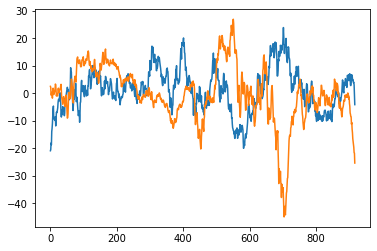

In [140]:
plt.plot(np.array(y_test))
plt.plot(np.array(predict_CNN))
plt.show()

In [112]:
np.expand_dims(y_test, axis = -1)

array([[-20.88353414],
       [-20.41237113],
       [-18.04979253],
       [-18.65828092],
       [-13.91304348],
       [-12.77056277],
       [-11.06290672],
       [ -7.92951542],
       [ -5.6768559 ],
       [ -4.62555066],
       [ -9.17030568],
       [ -9.26724138],
       [ -9.26724138],
       [ -9.85010707],
       [ -9.0712743 ],
       [ -8.47826087],
       [-11.85344828],
       [ -9.44206009],
       [ -6.88172043],
       [ -7.08154506],
       [ -6.91144708],
       [ -6.17021277],
       [ -5.2742616 ],
       [ -3.41880342],
       [ -2.35042735],
       [ -2.14132762],
       [ -2.80777538],
       [ -2.15053763],
       [ -0.21367521],
       [  0.21459227],
       [ -2.62008734],
       [ -3.50877193],
       [ -7.47863248],
       [ -8.62068966],
       [ -7.01754386],
       [ -6.12691466],
       [ -7.74193548],
       [ -4.79302832],
       [ -5.90809628],
       [ -5.48245614],
       [ -6.23655914],
       [ -6.63811563],
       [ -8.13704497],
       [ -7

In [113]:
y_test

array([-20.88353414, -20.41237113, -18.04979253, -18.65828092,
       -13.91304348, -12.77056277, -11.06290672,  -7.92951542,
        -5.6768559 ,  -4.62555066,  -9.17030568,  -9.26724138,
        -9.26724138,  -9.85010707,  -9.0712743 ,  -8.47826087,
       -11.85344828,  -9.44206009,  -6.88172043,  -7.08154506,
        -6.91144708,  -6.17021277,  -5.2742616 ,  -3.41880342,
        -2.35042735,  -2.14132762,  -2.80777538,  -2.15053763,
        -0.21367521,   0.21459227,  -2.62008734,  -3.50877193,
        -7.47863248,  -8.62068966,  -7.01754386,  -6.12691466,
        -7.74193548,  -4.79302832,  -5.90809628,  -5.48245614,
        -6.23655914,  -6.63811563,  -8.13704497,  -7.17391304,
        -1.86046512,  -2.55220418,  -2.55220418,  -3.71229698,
         0.        ,   0.71428571,   0.72115385,   2.20588235,
         0.96153846,   1.47783251,   0.24213075,  -2.15827338,
        -2.39808153,  -1.45985401,  -0.73891626,   0.49382716,
         3.29949239,   9.32642487,   6.58227848,   7.73

In [53]:
for epoch in range(n_epochs):
        X, labels = next_batch(X_train_4D, y_train, batch_size)

        grads = grad(model_CNN, X, labels)
        optimizer.apply_gradients(zip(grads, model_CNN.variables))
        loss = loss_fn(model_CNN, X, labels)
        train_MSE = evaluate(model_CNN, X, labels)

        test_MSE =  evaluate(model_CNN, X_test_4D, y_test)

        print('Epoch :', epoch+1, ' loss =', loss.numpy(), ' train MSE =', train_MSE.numpy(),' test MSE =', test_MSE.numpy())

Epoch : 1  loss = 478.65594  train MSE = 478.65594  test MSE = 58649733000000.0
Epoch : 2  loss = 639.9042  train MSE = 639.9042  test MSE = 54951766000000.0
Epoch : 3  loss = 333.96024  train MSE = 333.96024  test MSE = 49223880000000.0
Epoch : 4  loss = 851.3628  train MSE = 851.3628  test MSE = 44616087000000.0
Epoch : 5  loss = 93.473976  train MSE = 93.473976  test MSE = 40522740000000.0
Epoch : 6  loss = 1314.4886  train MSE = 1314.4886  test MSE = 37648210000000.0
Epoch : 7  loss = 260.53476  train MSE = 260.53476  test MSE = 34977849000000.0
Epoch : 8  loss = 973.346  train MSE = 973.346  test MSE = 33226850000000.0
Epoch : 9  loss = 206.98358  train MSE = 206.98358  test MSE = 30848630000000.0
Epoch : 10  loss = 445.55548  train MSE = 445.55548  test MSE = 28513682000000.0
Epoch : 11  loss = 202.9843  train MSE = 202.9843  test MSE = 26248516000000.0
Epoch : 12  loss = 1348.9167  train MSE = 1348.9167  test MSE = 25434220000000.0
Epoch : 13  loss = 253.38437  train MSE = 253.3

KeyboardInterrupt: 

In [59]:
logits = model_CNN(X, training = True)

In [60]:
logits

<tf.Tensor: id=1192368, shape=(20, 1), dtype=float32, numpy=
array([[3.8521044],
       [3.02193  ],
       [2.018183 ],
       [3.5595186],
       [3.4086463],
       [4.00454  ],
       [2.495425 ],
       [3.4965823],
       [3.3698356],
       [3.314314 ],
       [2.8059113],
       [3.7677057],
       [2.7676346],
       [3.6273441],
       [3.833732 ],
       [3.7255607],
       [2.5182974],
       [3.924812 ],
       [4.1107583],
       [4.660215 ]], dtype=float32)>

In [22]:
import os

In [47]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 

In [80]:
def create_model(time_step):
    with tf.device('/gpu:0') :
        inputs1 = keras.Input(shape = (time_step,10,1))
        conv1 = keras.layers.Conv2D(filters = 1, kernel_size = (1,10), padding = 'VALID', activation = tf.nn.elu,kernel_regularizer=keras.regularizers.l2(0.001))(inputs1)
    
    with tf.device('/gpu:1') :
        inputs2 = keras.Input(shape = (time_step,10,1))
        conv2 = keras.layers.Conv2D(filters = 1, kernel_size = (1,10), padding = 'VALID', activation = tf.nn.elu,kernel_regularizer=keras.regularizers.l2(0.001))(inputs2)
    
    with tf.device('/gpu:2') :
        inputs3 = keras.Input(shape = (time_step,10,1))
        conv3 = keras.layers.Conv2D(filters = 1, kernel_size = (1,10), padding = 'VALID', activation = tf.nn.elu,kernel_regularizer=keras.regularizers.l2(0.001))(inputs3)
    
    with tf.device('/gpu:3') :
        inputs = (inputs1,inputs2,inputs3)
        concat_layer = tf.concat([conv1, conv2,conv3], axis =2)
        CNN_output = tf.reshape (concat_layer,(-1,concat_layer.shape[1],concat_layer.shape[2]))

        #pool3_flat = keras.layers.Flatten()(pool3)
        #dense4 = keras.layers.Dense(units= 50,kernel_regularizer=keras.regularizers.l2(0.001), activation = tf.nn.elu)(pool2)
        #drop4 = keras.layers.Dropout(rate = 0.9)(dense4)
        #CNN_output = keras.layers.Dense(units = 50)(drop4)
        
        
        lstm5 = keras.layers.LSTM(units = 50, activation = tf.nn.relu6,return_sequences=True)(CNN_output)
        drop5 = keras.layers.TimeDistributed(keras.layers.Dropout(rate = .5))(lstm5)
        lstm6 = keras.layers.LSTM(units = 50, activation = tf.nn.relu6)(drop5)
        drop6 = keras.layers.Dropout(rate = .9)(lstm6)

        dense8 = keras.layers.Dense(units = 64)(drop6)
        drop8 = keras.layers.Dropout(rate = .9)(dense8)
        logits = keras.layers.Dense(units = 1)(drop8)

    return keras.Model(inputs = inputs, outputs = logits)

##Database connection successful!
[success] enterprise_absolute_value_indicator
[success] enterprise_consensus_estimate
[success] enterprise_dividend
[success] enterprise_financial_ratio
[success] enterprise_financial_statements
[success] enterprise_fixed_result_news
[success] enterprise_relative_value_indicator
[success] enterprise_stock
[success] enterprise_tentative_result
[success] market_financial_institution_reception_trend
[success] market_fund_investors
[success] market_money_around_market
[success] market_retirement_pension
[success] market_stock_cam
[success] market_trends_elw
[success] market_trends_investor_bond
[success] market_trends_investor_dollar
[success] market_trends_investor_eur
[success] market_trends_investor_gold
[success] market_trends_investor_index
[success] market_trends_investor_jpy
[success] market_trends_investor_pork
[success] market_trends_investor_rates
[success] market_trends_investor_stock
[success] market_trends_program
[success] economy_employ
[suc

In [24]:
training_part = corss_train_test_split(data)
part = 'part_1'
target_name = '수정주가(원)'
timestep = 100
future_day = 60

In [37]:
train_X, train_labels, test_X, test_labels = create_CNN_input_data(training_part, 'part_1',target_name,timestep,future_day)
learning_rate = 0.0001
training_epochs = 200
batch_size = 64

In [44]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [81]:
model = create_model(timestep)
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 100, 10, 1)] 0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           [(None, 100, 10, 1)] 0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           [(None, 100, 10, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 100, 1, 1)    11          input_49[0][0]                   
___________________________________________________________________________________________

In [79]:
keras.utils.plot_model(model, 'mini_resnet.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [18]:
def training(model, train_X,train_y, test_X, test_y, batch_size, n_epochs )
    for epoch in range(n_epochs):
        X, labels = next_batch(train_X, train_y, batch_size)

        grads = grad(model, X, labels)
        optimizer.apply_gradients(zip(grads, model.variables))
        loss = loss_fn(model, X, labels)
        train_MSE = evaluate(model, X, labels)

        test_MSE =  evaluate(model, test_X, test_y)

        print('Epoch :', epoch+1, ' loss =', loss.numpy(), ' train MSE =', train_MSE.numpy(),' test MSE =', test_MSE.numpy())
    return  model(test_X, training = False)


SyntaxError: invalid syntax (<ipython-input-18-1fa9a84d3d12>, line 1)

[<tf.Variable 'conv2d_64/kernel:0' shape=(5, 10, 1, 3) dtype=float32, numpy=
 array([[[[ 0.10874216,  0.16319056, -0.01177126]],
 
         [[ 0.10038777, -0.08204729, -0.07228488]],
 
         [[ 0.00611727,  0.02527888, -0.145368  ]],
 
         [[-0.09344019, -0.07780596, -0.0688545 ]],
 
         [[-0.13971315,  0.09860794,  0.04781915]],
 
         [[ 0.09211581,  0.1034332 , -0.04474393]],
 
         [[ 0.14119068, -0.06710611,  0.02539247]],
 
         [[ 0.12237725,  0.03345631,  0.1156529 ]],
 
         [[-0.11780613,  0.03479483,  0.15549444]],
 
         [[ 0.01143897,  0.10663389, -0.051325  ]]],
 
 
        [[[ 0.06886984,  0.12440365, -0.10400017]],
 
         [[-0.09398296,  0.09851002, -0.09748083]],
 
         [[-0.03611998, -0.00692982,  0.02656997]],
 
         [[-0.14225107,  0.08287907,  0.05146901]],
 
         [[-0.01668895, -0.13511951,  0.1285592 ]],
 
         [[-0.10419893,  0.1508516 ,  0.04065238]],
 
         [[ 0.16048689,  0.13095966,  0.04164167]],
 
  

In [31]:
predict = model(test_X, training = False)

In [26]:
def create_model(time_step):
    with tf.device('/gpu:1') :
        inputs = keras.Input(shape = (time_step,3917,1))
        conv1 = keras.layers.Conv2D(filters = 5, kernel_size = (5,10), strides=(1, 5),padding = 'SAME', activation = tf.nn.relu,kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
        pool1 = keras.layers.MaxPool2D(pool_size = (1,3),padding = 'SAME')(conv1)
        conv2 = keras.layers.Conv2D(filters = 5, kernel_size = (5,10),strides=(1, 5), padding = 'SAME', activation = tf.nn.relu,kernel_regularizer=keras.regularizers.l2(0.001))(pool1)
        pool2 = keras.layers.MaxPool2D(pool_size = (1,3),padding = 'same')(conv2)
        #pool3 = tf.reshape (pool3,(-1,200,15))
        pool2_flat = keras.layers.Flatten()(pool2)
        dense3 = keras.layers.Dense(units= 300,kernel_regularizer=keras.regularizers.l2(0.001), activation = tf.nn.tanh)(pool2_flat)
        drop3 = keras.layers.Dropout(rate = 0.2)(dense3)
        logits = keras.layers.Dense(units = 1)(drop3)
    return keras.Model(inputs = inputs, outputs = logits)

In [27]:
model = create_model(100)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 3917, 1)]    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 784, 5)       255       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 100, 262, 5)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 53, 5)        1255      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 100, 18, 5)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               2700

##Database connection successful!
[success] enterprise_absolute_value_indicator
[success] enterprise_consensus_estimate
[success] enterprise_dividend
[success] enterprise_financial_ratio
[success] enterprise_financial_statements
[success] enterprise_fixed_result_news
[success] enterprise_relative_value_indicator
[success] enterprise_stock
[success] enterprise_tentative_result
[success] market_financial_institution_reception_trend
[success] market_fund_investors
[success] market_money_around_market
[success] market_retirement_pension
[success] market_stock_cam
[success] market_trends_elw
[success] market_trends_investor_bond
[success] market_trends_investor_dollar
[success] market_trends_investor_eur
[success] market_trends_investor_gold
[success] market_trends_investor_index
[success] market_trends_investor_jpy
[success] market_trends_investor_pork
[success] market_trends_investor_rates
[success] market_trends_investor_stock
[success] market_trends_program
[success] economy_employ
[suc

In [20]:
train_X, train_labels, test_X, test_labels = create_CNN_input_data(training_part, 'part_1',target_name,timestep,future_day)

In [21]:
train_X, train_labels, test_X, test_labels = create_CNN_input_data(training_part, 'part_1',target_name,timestep,future_day)
learning_rate = 0.001
training_epochs = 200
batch_size = 100